In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.saving import register_keras_serializable
import pickle
import random

In [3]:
train_path = "train"
IMG_HEIGHT, IMG_WIDTH = 128, 128


In [5]:
image_files = [f for f in os.listdir(train_path) if f.endswith(".tif") and "_mask" not in f]
X, Y = [], []

for file in tqdm(image_files):
    img_path = os.path.join(train_path, file)
    mask_path = os.path.join(train_path, file.replace(".tif", "_mask.tif"))

    try:
        img = Image.open(img_path).convert('L').resize((IMG_WIDTH, IMG_HEIGHT))
        mask = Image.open(mask_path).convert('L').resize((IMG_WIDTH, IMG_HEIGHT))

        X.append(np.array(img) / 255.0)
        mask = np.expand_dims(np.array(mask) / 255.0, axis=-1)
        Y.append(mask)
    except Exception as e:
        print(f"Error loading {file}: {e}")

X = np.array(X).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
Y = np.array(Y).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

  0%|          | 0/5635 [00:00<?, ?it/s]

100%|██████████| 5635/5635 [02:13<00:00, 42.17it/s]


X shape: (5635, 128, 128, 1)
Y shape: (5635, 128, 128, 1)


In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [8]:
@register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

@register_keras_serializable()
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coefficient(y_true, y_pred)
    return bce + (1 - dice)

In [6]:
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)
    
    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(c)
        return c, p

    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    bn = conv_block(p4, 1024)

    u6 = decoder_block(bn, c4, 512)
    u7 = decoder_block(u6, c3, 256)
    u8 = decoder_block(u7, c2, 128)
    u9 = decoder_block(u8, c1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(u9)

    return models.Model(inputs, outputs)

In [7]:
def train_generator(X, Y, batch_size):
    data_gen_args = dict(rotation_range=10,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.1,
                         zoom_range=0.1,
                         horizontal_flip=True,
                         fill_mode='nearest')

    image_gen = ImageDataGenerator(**data_gen_args)
    mask_gen = ImageDataGenerator(**data_gen_args)

    seed = 42
    image_generator = image_gen.flow(X, batch_size=batch_size, seed=seed)
    mask_generator = mask_gen.flow(Y, batch_size=batch_size, seed=seed)

    while True:
        yield (next(image_generator), next(mask_generator))

In [8]:
model = unet_model()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coefficient, 'accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


In [10]:
batch_size = 16
steps_per_epoch = len(X_train) // batch_size
train_gen = train_generator(X_train, Y_train, batch_size)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, Y_val),
    epochs=25,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 2822s 10s/step - accuracy: 0.9749 - dice_coefficient: 0.0706 - loss: 1.2813 - val_accuracy: 0.9762 - val_dice_coefficient: 0.3082 - val_loss: 0.7644 - learning_rate: 0.0010
Epoch 2/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 1177s 4s/step - accuracy: 0.9802 - dice_coefficient: 0.3329 - loss: 0.7378 - val_accuracy: 0.9872 - val_dice_coefficient: 0.3256 - val_loss: 0.7972 - learning_rate: 0.0010
Epoch 3/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 1177s 4s/step - accuracy: 0.9817 - dice_coefficient: 0.3718 - loss: 0.7031 - val_accuracy: 0.9871 - val_dice_coefficient: 0.3865 - val_loss: 0.6594 - learning_rate: 0.0010
Epoch 4/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 1180s 4s/step - accuracy: 0.9814 - dice_coefficient: 0.4111 - loss: 0.6535 - val_accuracy: 0.9866 - val_dice_coefficient: 0.4807 - val_loss: 0.5831 - learning_rate: 0.0010
Epoch 5/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 1180s 4s/step - accuracy: 0.9828 - dice_coefficient: 0.4552 - loss: 0.6056 - val_accuracy: 0.9878 - val_dice_co

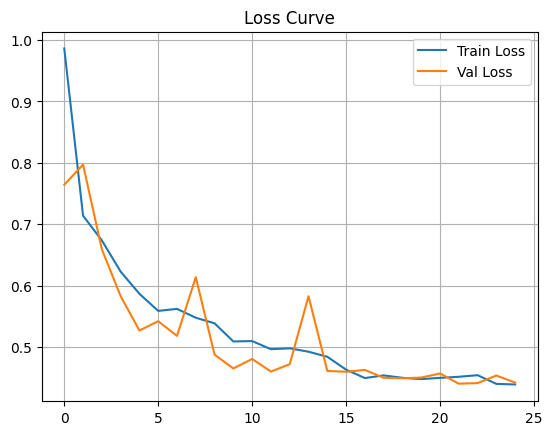

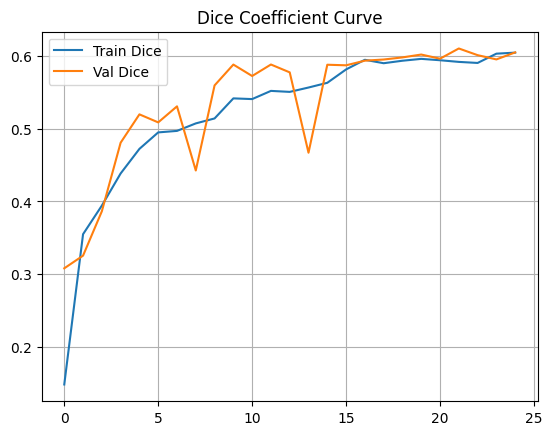

In [11]:
model.save("best_model.keras")
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Plot metrics
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.grid(True)
plt.show()

plt.plot(history.history['dice_coefficient'], label='Train Dice')
plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
plt.legend()
plt.title("Dice Coefficient Curve")
plt.grid(True)
plt.show()

In [9]:
model = load_model("best_model.keras", custom_objects={
    "dice_coefficient": dice_coefficient,
    "bce_dice_loss": bce_dice_loss
})

In [13]:
loss, accuracy, dice = model.evaluate(X_val, Y_val)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Dice: {dice:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9883 - dice_coefficient: 0.6229 - loss: 0.4245
Loss: 0.4405, Accuracy: 0.6101, Dice: 0.9881


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


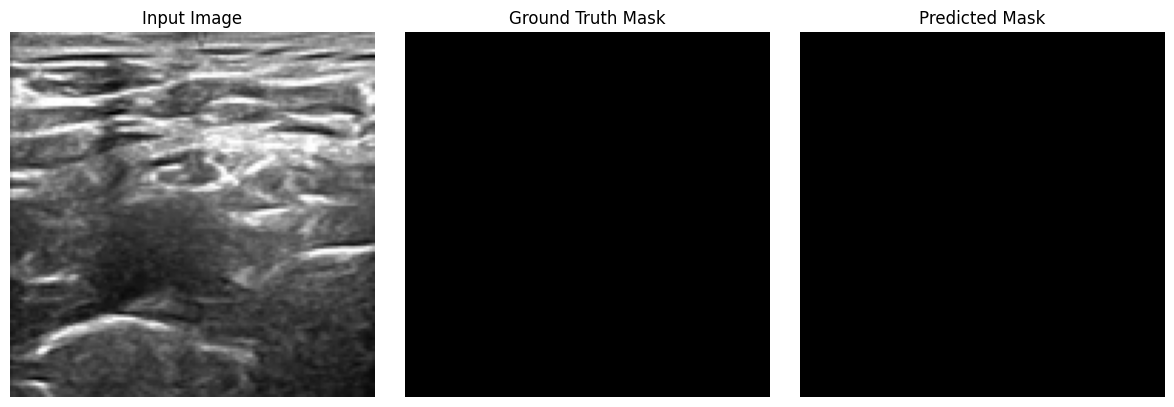

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


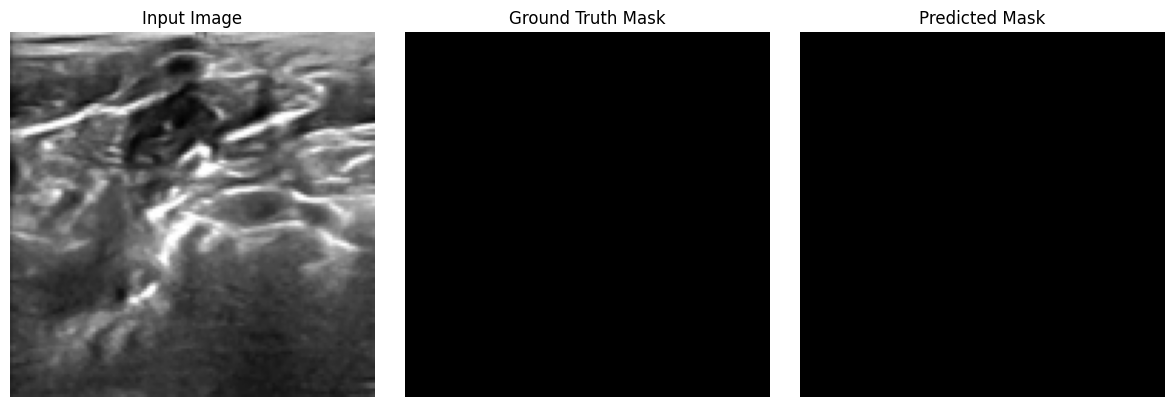

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


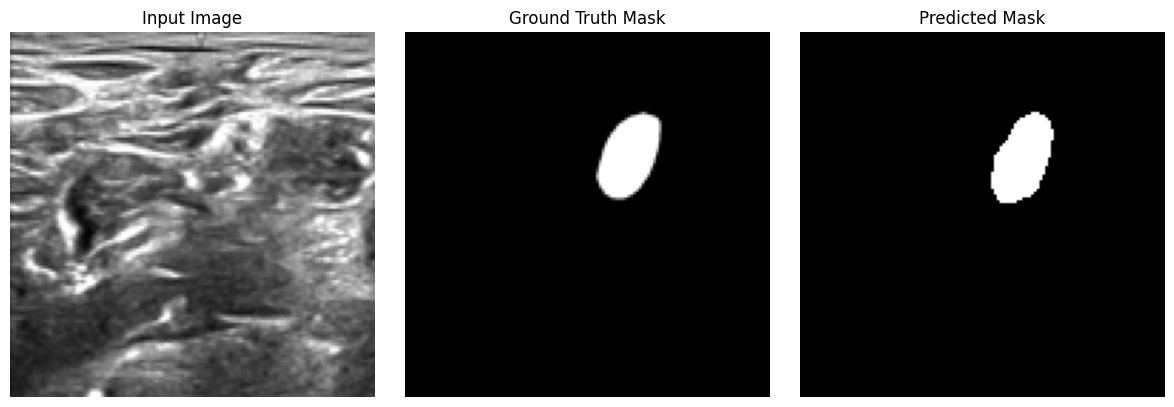

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


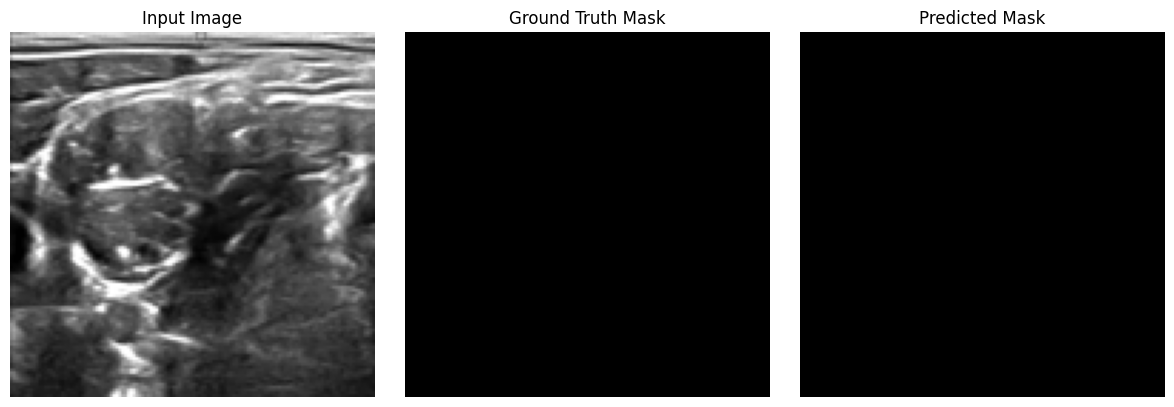

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


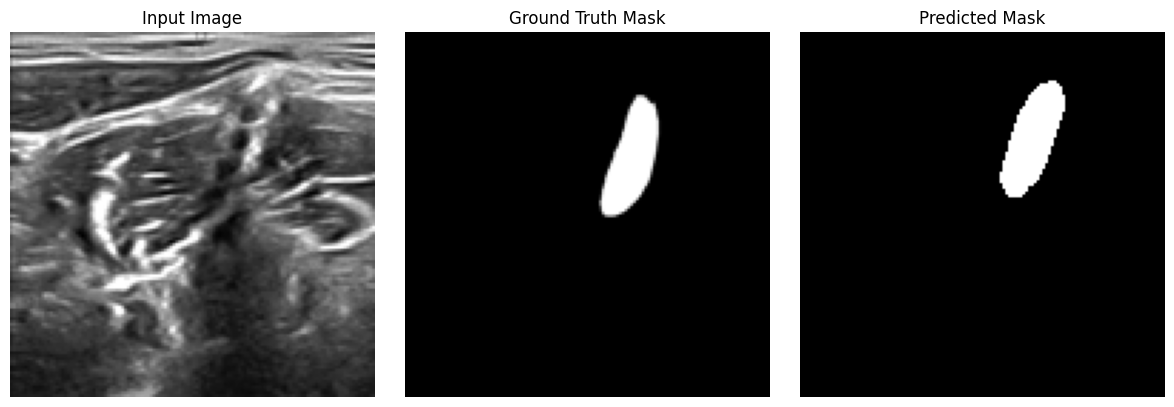

In [10]:
for _ in range(5):
    idx = random.randint(0, len(X_val)-1)
    sample_image = X_val[idx]
    sample_mask = Y_val[idx]
    pred_mask = model.predict(sample_image[np.newaxis, ...])[0] > 0.5

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(sample_image.squeeze(), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [15]:
def iou_score(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

print("Predicting on validation set...")
pred_masks = model.predict(X_val, batch_size=16, verbose=1) > 0.5

dice_scores, iou_scores = [], []
for i in range(len(X_val)):
    dice_scores.append(dice_coefficient(Y_val[i], pred_masks[i]).numpy())
    iou_scores.append(iou_score(Y_val[i], pred_masks[i]).numpy())

print(f"\nAverage Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"Average IoU Score: {np.mean(iou_scores):.4f}")


Predicting on validation set...
71/71 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step

Average Dice Coefficient: 0.6224
Average IoU Score: 0.5776
